# KE5105 - Building Electrical Consumption Forecasting

# Modelling 3 - Preliminary model

## Load libraries

In [1]:
import os
os.chdir(os.path.join(os.path.sep, 'home', 'tkokkeng', 'Documents', 'KE5105', 'ETL'))
os.getcwd()

'/home/tkokkeng/Documents/KE5105/ETL'

In [2]:
import sys
if os.path.join(os.getcwd(), 'source') not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), 'source'))
sys.path

['/home/tkokkeng/Documents/KE5105/ETL',
 '/home/tkokkeng/python/python367/tsfvenv/lib',
 '/home/tkokkeng/Documents/KE5105/ETL/source',
 '',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python36.zip',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/lib-dynload',
 '/usr/lib/python3.6',
 '/home/tkokkeng/.local/lib/python3.6/site-packages',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages/IPython/extensions',
 '/home/tkokkeng/.ipython']

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import datetime
import myUtilities as mu
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

Using TensorFlow backend.


## Load data for building AS5

In [4]:
as5_train = mu.load_data_by_bldg(['AS5'], 'imputed_train')

In [5]:
as5_train[0][1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62880 entries, 2015-06-01 00:00:00 to 2018-12-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         46164 non-null float64
PWMEXTAS4ExBldg                   46165 non-null float64
PWMAS4LanguageCenter              46165 non-null float64
PWMCANTEEN                        46164 non-null float64
PWMStreetLight                    46164 non-null float64
BTUAS5                            46175 non-null float64
PWMMainIC_30min_avg               46117 non-null float64
PWMEXTAS4ExBldg_30min_avg         46118 non-null float64
PWMAS4LanguageCenter_30min_avg    46118 non-null float64
PWMCANTEEN_30min_avg              46117 non-null float64
PWMStreetLight_30min_avg          46117 non-null float64
BTUAS5_30min_avg                  46129 non-null float64
PWM_sumadd                        46117 non-null float64
PWM_sumsubtract                   46117 non-null float64
PWM_30min_avg                     46117 non-null float64
B

In [ ]:
as5_train_df = as5_train[0][1]
as5_train_df['PWM_30min_avg'].plot(figsize=(25, 5), title='AS5 PWM')

In [ ]:
as5_train_df['BTU_30min_avg'].plot(figsize=(25, 5), title='AS5 BTU', color='orange')

## Split a validation set out from the train set

In [ ]:
as5_train_split_df = as5_train_df[:20000]
as5_val_split_df = as5_train_df[20000:]

In [ ]:
print('train split = %s\nvalidation split = %s' % (as5_train_split_df.shape, as5_val_split_df.shape))

## Transforming the training data
* Normalise the data - convert PWM and BTU values into the range 0 to 1
* Replace NaN with -1

In [ ]:
# Create a transformation pipleline to prepare the training dataset for RNN.
attrbs = ['PWM_30min_avg', 'BTU_30min_avg']
my_pipeline = Pipeline([
    ('selector', mu.DataFrameSelector(attrbs)),
    # ('yeo-johnson_transform', PowerTransformer(method='yeo-johnson', standardize=False, copy=True)),
    ('minmax_scaler', MinMaxScaler()),
    ('na_transform', mu.Nan_to_Num_Transformer())
])

In [ ]:
as5_train_data = my_pipeline.fit_transform(as5_train_split_df)
as5_train_data

In [ ]:
as5_train_data.shape

In [ ]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0])
plt.title('Normalised PWM Training Data')

In [ ]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 1], color='orange')
plt.title('Normalised BTU Training Data')

In [ ]:
as5_val_data = my_pipeline.transform(as5_val_split_df)
as5_val_data

In [ ]:
as5_val_data.shape

In [ ]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_val_data.shape[0]), as5_val_data[:, 0])
plt.title('Normalised PWM Validation Data')

In [ ]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_val_data.shape[0]), as5_val_data[:, 1], color='orange')
plt.title('Normalised BTU Validation Data')

## Parameters for the RNN model

Also used for generating the datasets with the lagged values 

In [12]:
lookback = 240  # 5 days; each day has 48 observations
step = 1  # sampling rate used for the lookback period
delay = 0  # 1 step ahead prediction
batch_size = 128

## Two-layer RNN Model (2 x 16)

In [ ]:
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)

In [18]:
model = Sequential()
model.add(layers.CUDNNGRU(16, return_sequences=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.CuDNNGRU(16))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [19]:
gen_train = mu.DataGenerator(as5_train_data,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_data,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_data) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

In [ ]:
callbacks_list = [
    ModelCheckpoint(
        filepath='base1-2x16gru.best.h5',
        monitor='val_loss',
        save_best_only=True
    ),
    TensorBoard(
        log_dir='tsb_log'
    )
]

### Train the RNN

In [22]:
t1 = datetime.datetime.now()
print('Training start time = {}'.format(t1))
history = model.fit_generator(generator=gen_train, epochs=80,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=0)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/80
143/143 [==============================] - 49s 340ms/step - loss: 0.0465 - mean_absolute_percentage_error: 29.0530 - val_loss: 0.0422 - val_mean_absolute_percentage_error: 20.5077
Epoch 2/80
143/143 [==============================] - 48s 337ms/step - loss: 0.0283 - mean_absolute_percentage_error: 19.3935 - val_loss: 0.0315 - val_mean_absolute_percentage_error: 16.0080
Epoch 3/80
143/143 [==============================] - 48s 336ms/step - loss: 0.0248 - mean_absolute_percentage_error: 17.2711 - val_loss: 0.0251 - val_mean_absolute_percentage_error: 12.9942
Epoch 4/80
143/143 [==============================] - 47s 330ms/step - loss: 0.0232 - mean_absolute_percentage_error: 15.9566 - val_loss: 0.0225 - val_mean_absolute_percentage_error: 12.6964
Epoch 5/80
143/143 [==============================] - 48s 334ms/step - loss: 0.0219 - mean_absolute_percentage_error: 15.2200 - val_loss: 0.0205 - val_mean_absolute_percentage_error: 10.6441
Epoch 6/80
143/143 [=========================

Epoch 44/80
143/143 [==============================] - 48s 336ms/step - loss: 0.0177 - mean_absolute_percentage_error: 11.5877 - val_loss: 0.0183 - val_mean_absolute_percentage_error: 9.1421
Epoch 45/80
143/143 [==============================] - 48s 334ms/step - loss: 0.0177 - mean_absolute_percentage_error: 11.6215 - val_loss: 0.0199 - val_mean_absolute_percentage_error: 9.5435
Epoch 46/80
Epoch 45/80
143/143 [==============================] - 48s 337ms/step - loss: 0.0177 - mean_absolute_percentage_error: 11.5312 - val_loss: 0.0182 - val_mean_absolute_percentage_error: 9.3581
Epoch 47/80
143/143 [==============================] - 48s 335ms/step - loss: 0.0176 - mean_absolute_percentage_error: 11.5553 - val_loss: 0.0193 - val_mean_absolute_percentage_error: 9.9423
Epoch 48/80
143/143 [==============================] - 48s 334ms/step - loss: 0.0177 - mean_absolute_percentage_error: 11.5879 - val_loss: 0.0177 - val_mean_absolute_percentage_error: 9.0498
Epoch 49/80
143/143 [============

In [ ]:
histories = [] # for first training session
histories.append(history.history)

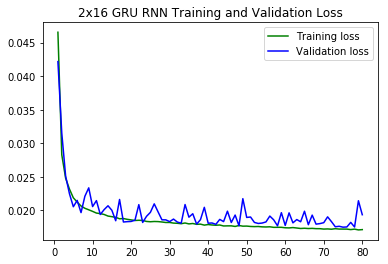

In [25]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in h['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Base 2x16 GRU Model\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('Base 2x16 GRU Model\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [ ]:
print('min validation loss = {}\nepoch = {}'.format(min(val_loss), val_loss.index(min(val_loss))))

In [38]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.817923
Validation MAE = 1.861494


In [ ]:
# Load best model
best_model = load_model(os.path.join('models', 'base1-2x16gru.best.h5'))
best_model.summary()

In [27]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = best_model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
as5_train_preds.shape

(18304, 1)

In [ ]:
as5_train_preds1 = np.concatenate([as5_train_preds, np.zeros((as5_train_preds.shape[0], 1))], axis=1)
as5_train_preds1.shape

In [ ]:
as5_train_preds1 = my_pipeline.inverse_transform(as5_train_preds1)
as5_train_preds1

In [ ]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds1[j, 0]
        j += 1
as5_train_preds_withnan.shape

In [ ]:
gen_val_pred = mu.DataGenerator(as5_val_data,
                                lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_data) - 1,
                                batch_size=batch_size, step=step)
as5_val_preds = best_model.predict_generator(gen_val_pred, workers=3, use_multiprocessing=False)
as5_val_preds.shape

In [ ]:
as5_val_preds1 = np.concatenate([as5_val_preds, np.zeros((as5_val_preds.shape[0], 1))], axis=1)
as5_val_preds1 = my_pipeline.inverse_transform(as5_val_preds1)
as5_val_preds_withnan = np.full((as5_val_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_val_data)):
    if as5_val_data[i, 0] > -1:
        as5_val_preds_withnan[i] = as5_val_preds1[j, 0]
        j += 1
as5_val_preds_withnan.shape

In [ ]:
plt.figure(figsize=(25, 5))
plt.plot(as5_train_df['PWM_30min_avg'])
plt.plot(as5_train_df.index[:20000], as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.plot(as5_train_df.index[20000:], as5_val_preds_withnan.flatten(), color='tan', alpha=.5, label='val rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

In [ ]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(as5_train_df.iloc[1000:1500, as5_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(as5_train_df.index[1000:1500], as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(as5_train_df.iloc[1240:1300, as5_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(as5_train_df.index[1240:1300], as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(as5_train_df.index[1241:1301], as5_train_df.iloc[1240:1300, as5_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(as5_train_df.iloc[20000:20500, as5_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(as5_train_df.index[20000:20500], as5_val_preds_withnan[:500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(as5_train_df.iloc[20390:20450, as5_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(as5_train_df.index[20390:20450], as5_val_preds_withnan[390:450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(as5_train_df.index[20391:20451], as5_train_df.iloc[20390:20450, as5_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1
plt.title('Validation PWM Data vs Predictions')
plt.legend(

In [33]:
model.save('base1-2x16gru.h5')

In [ ]:
with open('base1-2x16gru-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

## Two-layer RNN Model (2 x 32)

In [17]:
model = Sequential()
model.add(layers.GRU(32, return_sequences=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.GRU(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [18]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [19]:
gen_train.__len__()

143

In [20]:
gen_val.__len__()

88

In [21]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=80,
                              validation_data=gen_val,
                              workers=4, use_multiprocessing=True, shuffle=True)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/80
143/143 [==============================] - 49s 346ms/step - loss: 0.0424 - mean_absolute_percentage_error: 27.3669 - val_loss: 0.0344 - val_mean_absolute_percentage_error: 19.6518
Epoch 2/80
143/143 [==============================] - 51s 354ms/step - loss: 0.0273 - mean_absolute_percentage_error: 18.7684 - val_loss: 0.0232 - val_mean_absolute_percentage_error: 11.8439
Epoch 3/80
143/143 [==============================] - 49s 339ms/step - loss: 0.0242 - mean_absolute_percentage_error: 16.8960 - val_loss: 0.0215 - val_mean_absolute_percentage_error: 11.3675
Epoch 4/80
143/143 [==============================] - 47s 332ms/step - loss: 0.0225 - mean_absolute_percentage_error: 15.5205 - val_loss: 0.0211 - val_mean_absolute_percentage_error: 11.8639
Epoch 5/80
143/143 [==============================] - 47s 332ms/step - loss: 0.0214 - mean_absolute_percentage_error: 14.6662 - val_loss: 0.0240 - val_mean_absolute_percentage_error: 12.8976
Epoch 6/80
143/143 [=========================

Epoch 44/80
143/143 [==============================] - 48s 337ms/step - loss: 0.0177 - mean_absolute_percentage_error: 11.5728 - val_loss: 0.0182 - val_mean_absolute_percentage_error: 9.5824
Epoch 45/80
143/143 [==============================] - 48s 333ms/step - loss: 0.0176 - mean_absolute_percentage_error: 11.6097 - val_loss: 0.0201 - val_mean_absolute_percentage_error: 9.5706
Epoch 46/80
143/143 [==============================] - 48s 336ms/step - loss: 0.0176 - mean_absolute_percentage_error: 11.5775 - val_loss: 0.0182 - val_mean_absolute_percentage_error: 9.1823
Epoch 47/80
143/143 [==============================] - 47s 331ms/step - loss: 0.0176 - mean_absolute_percentage_error: 11.5223 - val_loss: 0.0174 - val_mean_absolute_percentage_error: 9.1303
Epoch 48/80
143/143 [==============================] - 48s 334ms/step - loss: 0.0176 - mean_absolute_percentage_error: 11.6830 - val_loss: 0.0178 - val_mean_absolute_percentage_error: 9.0833
Epoch 49/80
143/143 [========================

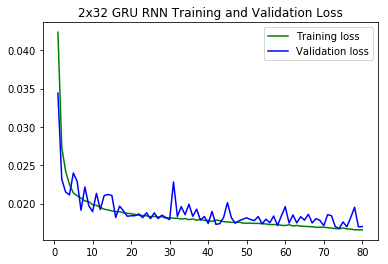

In [22]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.figure()
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('2x32 GRU RNN Training and Validation Loss')
plt.legend()
plt.show()

In [23]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.762820
Validation MAE = 1.781266


In [24]:
as5_train_preds = model.predict_generator(gen_train, workers=4, use_multiprocessing=True)
as5_train_preds.shape

(18304, 1)

In [25]:
as5_train_preds_withnan = np.full((as5_train_split.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_split)):
    if as5_train_split[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(20000, 1)

In [26]:
as5_val_preds = model.predict_generator(gen_val, workers=4, use_multiprocessing=True)
as5_val_preds.shape

(11223, 1)

In [27]:
as5_val_preds_withnan = np.full((as5_val_split.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_val_split)):
    if as5_val_split[i, 0] > -1:
        as5_val_preds_withnan[i] = as5_val_preds[j]
        j += 1
as5_val_preds_withnan.shape

(11616, 1)

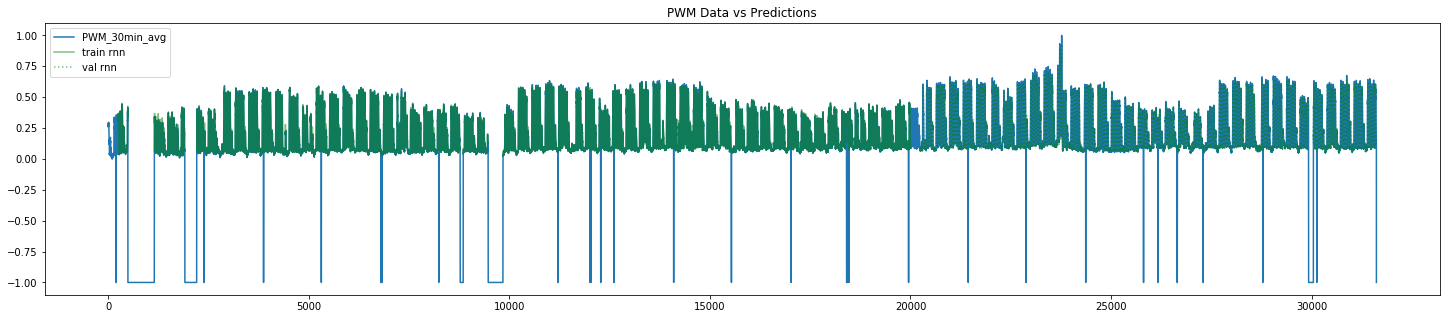

In [28]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_split.shape[0]), as5_train_preds_withnan.flatten(), color='green', alpha=.5, label='train rnn')
plt.plot(range(20000, 20000 + as5_val_split.shape[0]), as5_val_preds_withnan.flatten(), color='green', alpha=.5, label='val rnn', linestyle=':')
plt.title('PWM Data vs Predictions')
plt.legend()

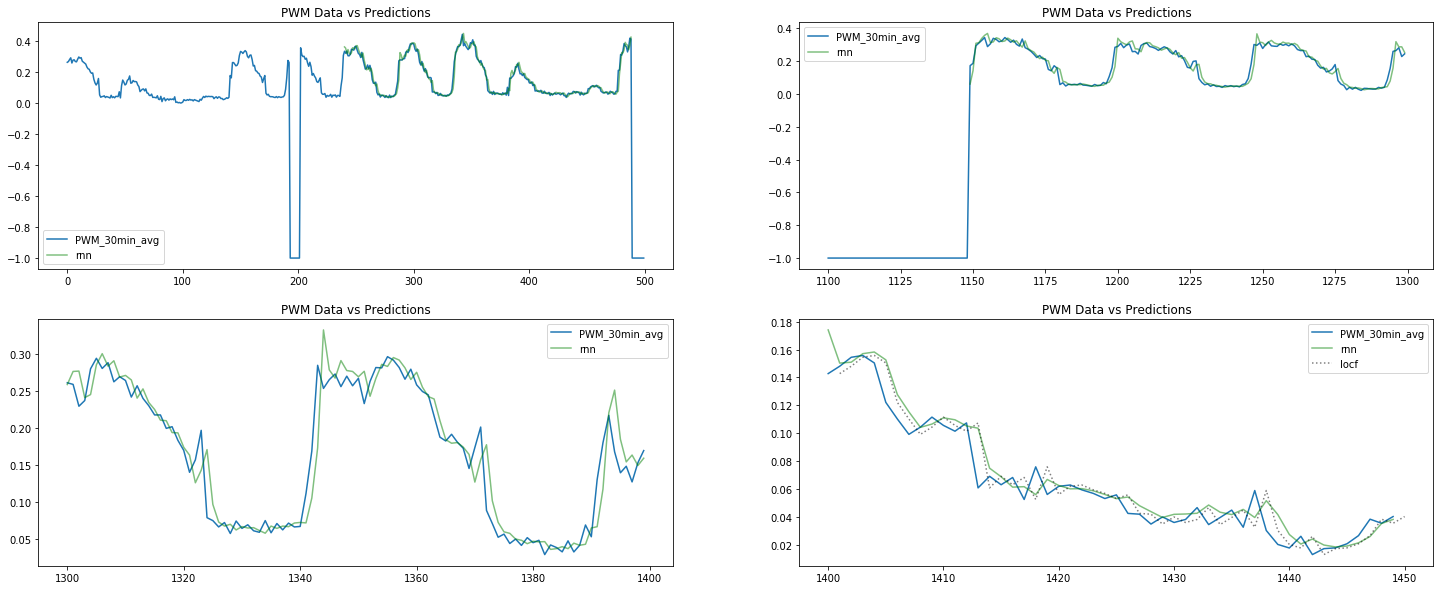

In [29]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(500), as5_train_data[:500, 0], label='PWM_30min_avg')
plt.plot(range(500), as5_train_preds_withnan[:500, :].flatten(), color='green', alpha=.5, label='rnn')
plt.title('PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1100, 1300), as5_train_data[1100:1300, 0], label='PWM_30min_avg')
plt.plot(range(1100, 1300), as5_train_preds_withnan[1100:1300].flatten(), color='green', alpha=.5, label='rnn')
plt.title('PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(1300, 1400), as5_train_data[1300:1400, 0], label='PWM_30min_avg')
plt.plot(range(1300, 1400), as5_train_preds_withnan[1300:1400].flatten(), color='green', alpha=.5, label='rnn')
plt.title('PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(1400, 1450), as5_train_data[1400:1450, 0], label='PWM_30min_avg')
plt.plot(range(1400, 1450), as5_train_preds_withnan[1400:1450].flatten(), color='green', alpha=.5, label='rnn')
plt.plot(range(1401, 1451), as5_train_data[1400:1450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('PWM Data vs Predictions')
plt.legend()

In [30]:
model.save('base-2x32gru-nomask-val.h5')

## Three-layer RNN Model (3 x 32)

In [19]:
model = Sequential()
model.add(layers.GRU(32, return_sequences=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.GRU(32, return_sequences=True))
model.add(layers.GRU(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])


In [20]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [21]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=120,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=True, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/120
 - 70s - loss: 0.0511 - mean_absolute_percentage_error: 32.9781 - val_loss: 0.0339 - val_mean_absolute_percentage_error: 19.3048
Epoch 2/120
 - 69s - loss: 0.0316 - mean_absolute_percentage_error: 21.4666 - val_loss: 0.0341 - val_mean_absolute_percentage_error: 17.1465
Epoch 3/120
 - 68s - loss: 0.0276 - mean_absolute_percentage_error: 18.7905 - val_loss: 0.0304 - val_mean_absolute_percentage_error: 17.1525
Epoch 4/120
 - 68s - loss: 0.0246 - mean_absolute_percentage_error: 17.0927 - val_loss: 0.0223 - val_mean_absolute_percentage_error: 12.1997
Epoch 5/120
 - 68s - loss: 0.0233 - mean_absolute_percentage_error: 16.1133 - val_loss: 0.0290 - val_mean_absolute_percentage_error: 14.7481
Epoch 6/120
 - 69s - loss: 0.0225 - mean_absolute_percentage_error: 15.3696 - val_loss: 0.0237 - val_mean_absolute_percentage_error: 12.8909
Epoch 7/120
 - 68s - loss: 0.0218 - mean_absolute_percentage_error: 14.6888 - val_loss: 0.0252 - val_mean_absolute_percentage_error: 12.6496
Epoch 8/120
 

Epoch 59/120
 - 68s - loss: 0.0174 - mean_absolute_percentage_error: 11.5230 - val_loss: 0.0187 - val_mean_absolute_percentage_error: 9.3769
Epoch 60/120
 - 68s - loss: 0.0173 - mean_absolute_percentage_error: 11.4826 - val_loss: 0.0185 - val_mean_absolute_percentage_error: 9.9503
Epoch 61/120
 - 68s - loss: 0.0173 - mean_absolute_percentage_error: 11.3609 - val_loss: 0.0186 - val_mean_absolute_percentage_error: 9.4893
Epoch 62/120
 - 68s - loss: 0.0172 - mean_absolute_percentage_error: 11.4171 - val_loss: 0.0188 - val_mean_absolute_percentage_error: 9.0192
Epoch 63/120
 - 68s - loss: 0.0173 - mean_absolute_percentage_error: 11.3587 - val_loss: 0.0219 - val_mean_absolute_percentage_error: 10.0618
Epoch 64/120
 - 68s - loss: 0.0172 - mean_absolute_percentage_error: 11.4153 - val_loss: 0.0177 - val_mean_absolute_percentage_error: 9.2444
Epoch 65/120
 - 68s - loss: 0.0172 - mean_absolute_percentage_error: 11.4386 - val_loss: 0.0181 - val_mean_absolute_percentage_error: 9.3050
Epoch 66/120

Epoch 117/120
 - 68s - loss: 0.0156 - mean_absolute_percentage_error: 10.4729 - val_loss: 0.0177 - val_mean_absolute_percentage_error: 9.0026
Epoch 118/120
 - 68s - loss: 0.0155 - mean_absolute_percentage_error: 10.5156 - val_loss: 0.0177 - val_mean_absolute_percentage_error: 8.7796
Epoch 119/120
 - 68s - loss: 0.0155 - mean_absolute_percentage_error: 10.4349 - val_loss: 0.0173 - val_mean_absolute_percentage_error: 8.9021
Epoch 120/120
 - 68s - loss: 0.0154 - mean_absolute_percentage_error: 10.4657 - val_loss: 0.0172 - val_mean_absolute_percentage_error: 8.7310

Training Duration = 2:16:29.327572


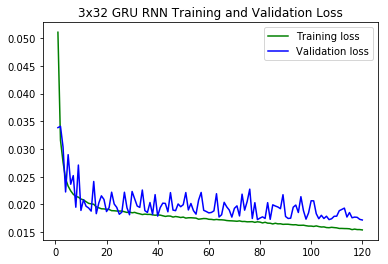

In [22]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.figure()
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('3x32 GRU RNN Training and Validation Loss')
plt.legend()
plt.show()

In [23]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.639363
Validation MAE = 1.829792


In [27]:
as5_train_preds = model.predict_generator(gen_train, workers=3, use_multiprocessing=True)
as5_train_preds.shape

(18304, 1)

In [28]:
as5_train_preds_withnan = np.full((as5_train_split.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_split)):
    if as5_train_split[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(20000, 1)

In [29]:
as5_val_preds = model.predict_generator(gen_val, workers=3, use_multiprocessing=True)
as5_val_preds.shape

(11223, 1)

In [30]:
as5_val_preds_withnan = np.full((as5_val_split.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_val_split)):
    if as5_val_split[i, 0] > -1:
        as5_val_preds_withnan[i] = as5_val_preds[j]
        j += 1
as5_val_preds_withnan.shape

(11616, 1)

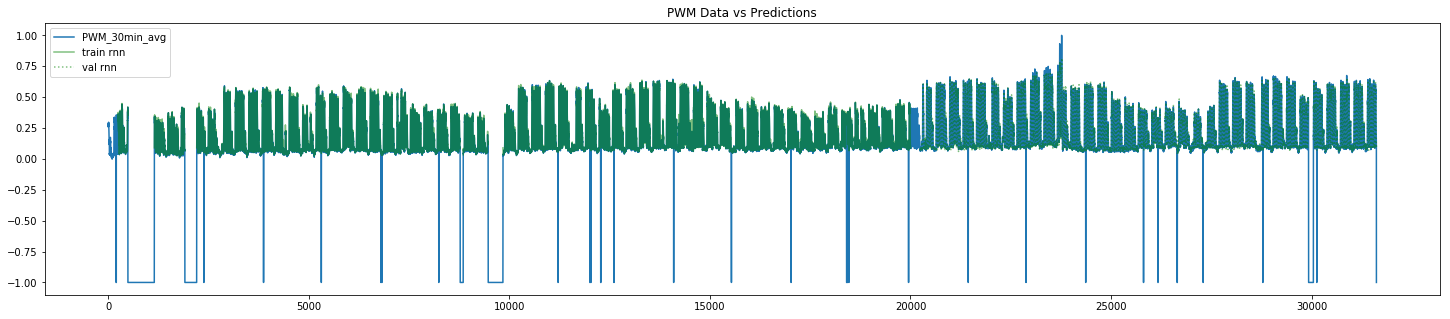

In [31]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_split.shape[0]), as5_train_preds_withnan.flatten(), color='green', alpha=.5, label='train rnn')
plt.plot(range(20000, 20000 + as5_val_split.shape[0]), as5_val_preds_withnan.flatten(), color='green', alpha=.5, label='val rnn', linestyle=':')
plt.title('PWM Data vs Predictions')
plt.legend()

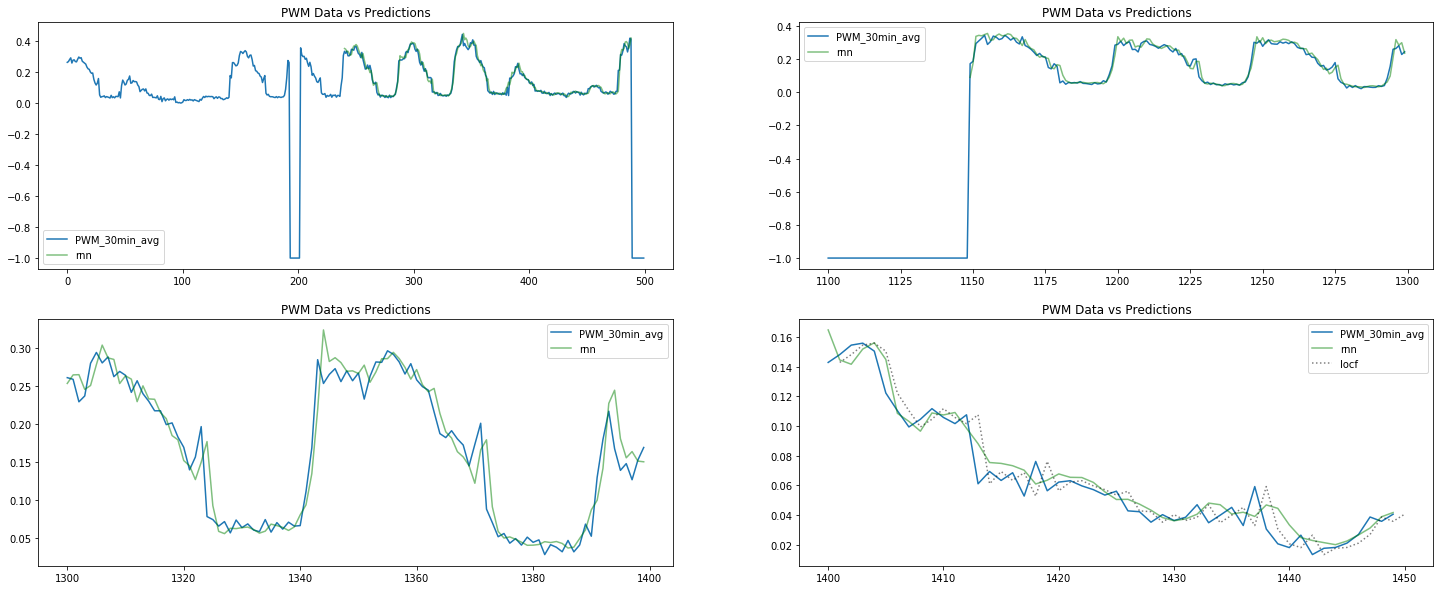

In [32]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(500), as5_train_data[:500, 0], label='PWM_30min_avg')
plt.plot(range(500), as5_train_preds_withnan[:500, :].flatten(), color='green', alpha=.5, label='rnn')
plt.title('PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1100, 1300), as5_train_data[1100:1300, 0], label='PWM_30min_avg')
plt.plot(range(1100, 1300), as5_train_preds_withnan[1100:1300].flatten(), color='green', alpha=.5, label='rnn')
plt.title('PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(1300, 1400), as5_train_data[1300:1400, 0], label='PWM_30min_avg')
plt.plot(range(1300, 1400), as5_train_preds_withnan[1300:1400].flatten(), color='green', alpha=.5, label='rnn')
plt.title('PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(1400, 1450), as5_train_data[1400:1450, 0], label='PWM_30min_avg')
plt.plot(range(1400, 1450), as5_train_preds_withnan[1400:1450].flatten(), color='green', alpha=.5, label='rnn')
plt.plot(range(1401, 1451), as5_train_data[1400:1450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('PWM Data vs Predictions')
plt.legend()

In [33]:
model.save('base-3x32gru-nomask-val.h5')

In [34]:
with open('base-3x32gru-nomask-val-history.pkl', 'wb') as outfile:
    pickle.dump(history.history, outfile)

## Four-layer RNN Model (4x32)

In [19]:
model = Sequential()
model.add(layers.GRU(32, return_sequences=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.GRU(32, return_sequences=True))
model.add(layers.GRU(32, return_sequences=True))
model.add(layers.GRU(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [20]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [21]:
gen_train.__len__()

143

In [22]:
gen_val.__len__()

88

In [23]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=120,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=True, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/120
 - 93s - loss: 0.0552 - mean_absolute_percentage_error: 35.7913 - val_loss: 0.0338 - val_mean_absolute_percentage_error: 16.8531
Epoch 2/120
 - 93s - loss: 0.0350 - mean_absolute_percentage_error: 23.4768 - val_loss: 0.0352 - val_mean_absolute_percentage_error: 16.7520
Epoch 3/120
 - 93s - loss: 0.0292 - mean_absolute_percentage_error: 20.0294 - val_loss: 0.0234 - val_mean_absolute_percentage_error: 11.9257
Epoch 4/120
 - 93s - loss: 0.0258 - mean_absolute_percentage_error: 17.5392 - val_loss: 0.0208 - val_mean_absolute_percentage_error: 10.8396
Epoch 5/120
 - 92s - loss: 0.0245 - mean_absolute_percentage_error: 16.2291 - val_loss: 0.0198 - val_mean_absolute_percentage_error: 10.8510
Epoch 6/120
 - 94s - loss: 0.0238 - mean_absolute_percentage_error: 16.0959 - val_loss: 0.0220 - val_mean_absolute_percentage_error: 11.2740
Epoch 7/120
 - 94s - loss: 0.0229 - mean_absolute_percentage_error: 15.4197 - val_loss: 0.0219 - val_mean_absolute_percentage_error: 11.2340
Epoch 8/120
 

Epoch 59/120
 - 91s - loss: 0.0175 - mean_absolute_percentage_error: 11.6561 - val_loss: 0.0196 - val_mean_absolute_percentage_error: 9.9938
Epoch 60/120
 - 91s - loss: 0.0175 - mean_absolute_percentage_error: 11.4970 - val_loss: 0.0181 - val_mean_absolute_percentage_error: 9.1698
Epoch 61/120
 - 91s - loss: 0.0173 - mean_absolute_percentage_error: 11.4812 - val_loss: 0.0177 - val_mean_absolute_percentage_error: 9.0001
Epoch 62/120
 - 91s - loss: 0.0173 - mean_absolute_percentage_error: 11.5488 - val_loss: 0.0188 - val_mean_absolute_percentage_error: 9.9148
Epoch 63/120
 - 91s - loss: 0.0172 - mean_absolute_percentage_error: 11.4561 - val_loss: 0.0216 - val_mean_absolute_percentage_error: 11.5298
Epoch 64/120
 - 92s - loss: 0.0173 - mean_absolute_percentage_error: 11.5176 - val_loss: 0.0177 - val_mean_absolute_percentage_error: 8.9734
Epoch 65/120
 - 92s - loss: 0.0172 - mean_absolute_percentage_error: 11.4439 - val_loss: 0.0208 - val_mean_absolute_percentage_error: 10.3278
Epoch 66/12

Epoch 117/120
 - 92s - loss: 0.0152 - mean_absolute_percentage_error: 10.2775 - val_loss: 0.0171 - val_mean_absolute_percentage_error: 8.2492
Epoch 118/120
 - 92s - loss: 0.0151 - mean_absolute_percentage_error: 10.2334 - val_loss: 0.0170 - val_mean_absolute_percentage_error: 8.5061
Epoch 119/120
 - 91s - loss: 0.0151 - mean_absolute_percentage_error: 10.2932 - val_loss: 0.0190 - val_mean_absolute_percentage_error: 8.9511
Epoch 120/120
 - 93s - loss: 0.0150 - mean_absolute_percentage_error: 10.1291 - val_loss: 0.0173 - val_mean_absolute_percentage_error: 8.5767

Training Duration = 3:05:04.288817


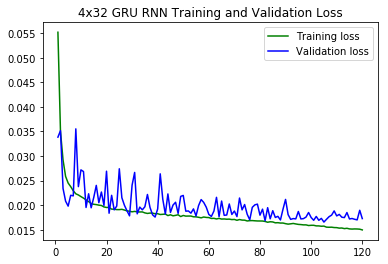

In [34]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.figure()
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('4x32 GRU RNN Training and Validation Loss')
plt.legend()
plt.show()

In [25]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.591651
Validation MAE = 1.761605


In [26]:
as5_train_preds = model.predict_generator(gen_train, workers=4, use_multiprocessing=True)
as5_train_preds.shape

(18304, 1)

In [27]:
as5_train_preds_withnan = np.full((as5_train_split.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_split)):
    if as5_train_split[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(20000, 1)

In [28]:
as5_val_preds = model.predict_generator(gen_val, workers=4, use_multiprocessing=True)
as5_val_preds.shape

(11223, 1)

In [29]:
as5_val_preds_withnan = np.full((as5_val_split.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_val_split)):
    if as5_val_split[i, 0] > -1:
        as5_val_preds_withnan[i] = as5_val_preds[j]
        j += 1
as5_val_preds_withnan.shape

(11616, 1)

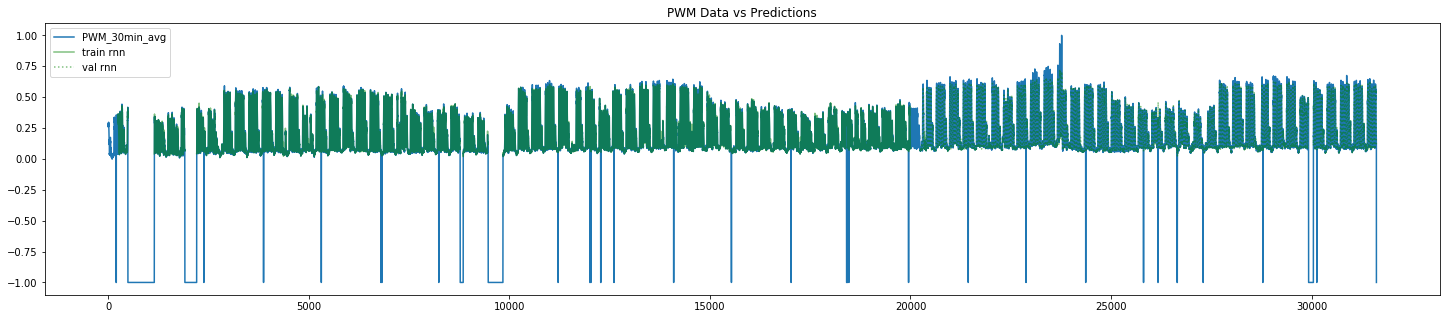

In [30]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_split.shape[0]), as5_train_preds_withnan.flatten(), color='green', alpha=.5, label='train rnn')
plt.plot(range(20000, 20000 + as5_val_split.shape[0]), as5_val_preds_withnan.flatten(), color='green', alpha=.5, label='val rnn', linestyle=':')
plt.title('PWM Data vs Predictions')
plt.legend()

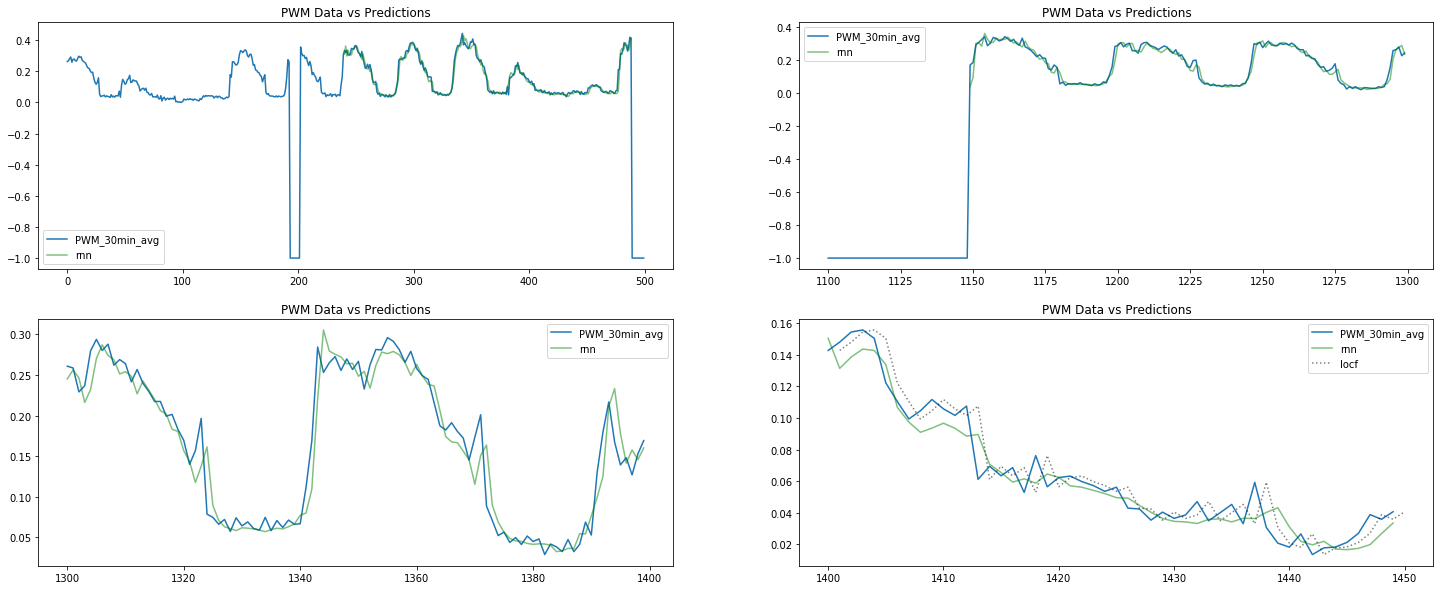

In [31]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(500), as5_train_data[:500, 0], label='PWM_30min_avg')
plt.plot(range(500), as5_train_preds_withnan[:500, :].flatten(), color='green', alpha=.5, label='rnn')
plt.title('PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1100, 1300), as5_train_data[1100:1300, 0], label='PWM_30min_avg')
plt.plot(range(1100, 1300), as5_train_preds_withnan[1100:1300].flatten(), color='green', alpha=.5, label='rnn')
plt.title('PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(1300, 1400), as5_train_data[1300:1400, 0], label='PWM_30min_avg')
plt.plot(range(1300, 1400), as5_train_preds_withnan[1300:1400].flatten(), color='green', alpha=.5, label='rnn')
plt.title('PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(1400, 1450), as5_train_data[1400:1450, 0], label='PWM_30min_avg')
plt.plot(range(1400, 1450), as5_train_preds_withnan[1400:1450].flatten(), color='green', alpha=.5, label='rnn')
plt.plot(range(1401, 1451), as5_train_data[1400:1450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('PWM Data vs Predictions')
plt.legend()

In [32]:
model.save('base-4x32gru-nomask-val.h5')

In [33]:
with open('base-4x32gru-nomask-val-history.pkl', 'wb') as outfile:
    pickle.dump(history.history, outfile)